In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

from kalman_experiments.kalman import Colored1DMatsudaKF, plv, env_cor
from kalman_experiments.gen_ar_noise import ArNoise
from kalman_experiments.models import SingleRhythmModel
from kalman_experiments.cfir import CFIRBandDetector
from kalman_experiments.complex import complex2mat, vec2complex
from kalman_experiments.me

$$x_{k+1} = A e^{\frac{2 \pi i f}{sr}} x_k + \nu, \nu \sim N(0, \sigma ^ 2)$$

<IPython.core.display.Javascript object>


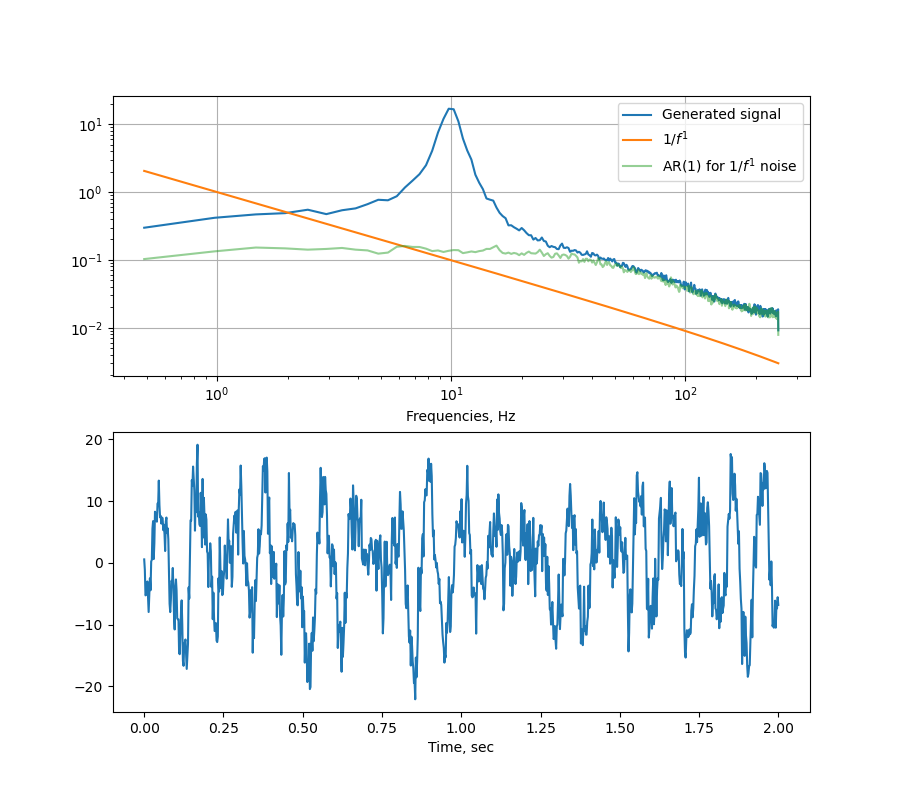

In [2]:
srate = 500
oscillation_freq = 10
A = 0.99          # as in x_next = A*exp(2*pi*oscillation_freq / sr)
signal_sigma = 1  # var of the model-driving white noise in the Matsuda model
noise_ar_order = 1
alpha = 1
noise_sigma = 3  # var of white noise driving the ar model for the colored noise

meas_noise = ArNoise(y0=np.random.rand(noise_ar_order), alpha=alpha, order=noise_ar_order, sigma=noise_sigma)
model = SingleRhythmModel(freq=oscillation_freq, A=A, sigma=signal_sigma, sr=srate, meas_noise=meas_noise)

n_samp = 100_000
noise_samples = np.array([meas_noise.step() for _ in range(n_samp)])
freqs, psd_noise = welch(noise_samples, fs=srate, nperseg=1024)
sig_samples = np.array([model.step() for _ in range(n_samp)])
freqs, psd_signal = welch(sig_samples, fs=srate, nperseg=1024)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 8))
freq_lim = 1000
ax1.loglog(freqs[1:freq_lim], psd_signal[1:freq_lim])
ax1.loglog(freqs[1:freq_lim], [1 / f**alpha - 0.001 for f in freqs[1:freq_lim]])
ax1.loglog(freqs[1:freq_lim], psd_noise[1:freq_lim], alpha=0.5)

ax1.legend([f"AR({noise_ar_order}) for 1/f noise", "1/f", "noise"])
ax1.legend(["Generated signal", f"$1/f^{ {alpha} }$", f"AR({noise_ar_order})" f" for $1/f^{ {alpha} }$ noise"])
ax1.set_xlabel("Frequencies, Hz")
ax1.grid()
ax2.plot(np.linspace(0, 2, 1000), sig_samples[:1000])
ax2.set_xlabel("Time, sec")

plt.show()

<IPython.core.display.Javascript object>


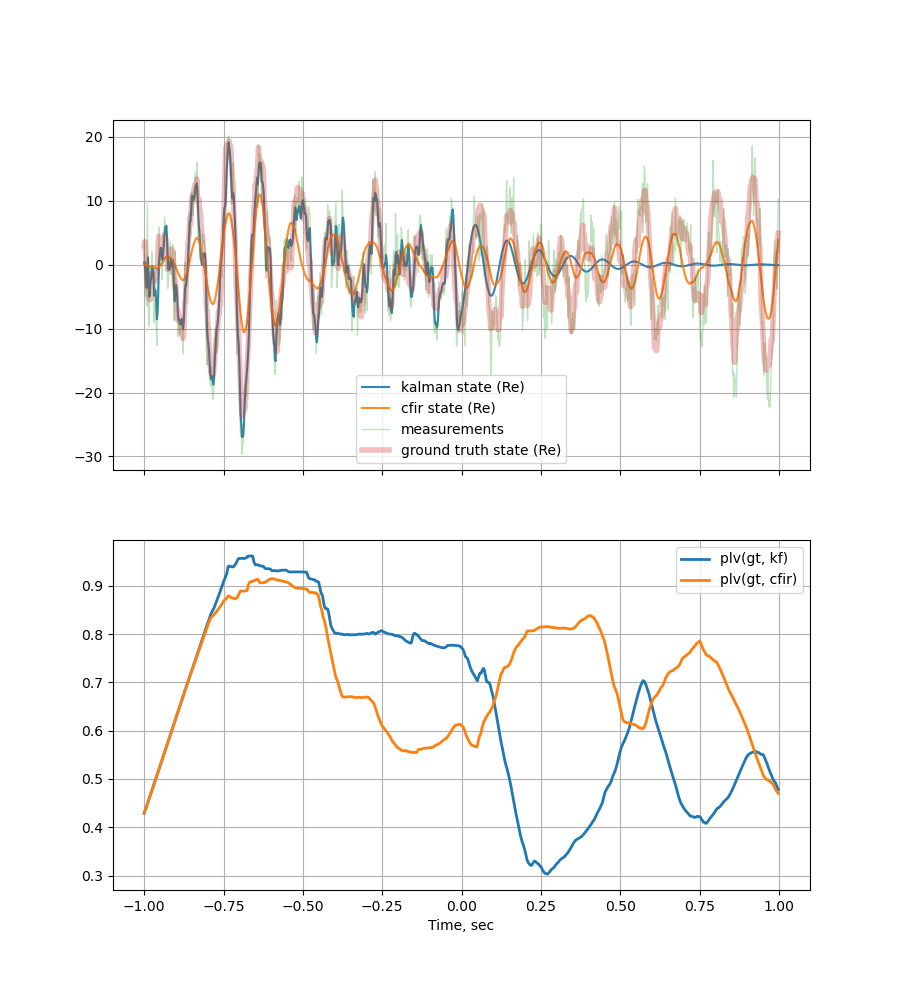

np.abs(plv_tot_kf)=0.8482678739251094, np.abs(plv_tot_cfir)=0.7324065157446386


In [5]:

track_nsamp, predict_nsamp = 500, 500

kf = Colored1DMatsudaKF(A=A, f=oscillation_freq, sr=srate, q_sigma=signal_sigma, psi=-0.5, r_sigma=noise_sigma) 

gt_states = []
kf_states = []
meas = []
for i in range(track_nsamp):
    y = model.step()
    gt_states.append(model.x)
    meas.append(y)
    kf_states.append(vec2complex(kf.step(y).mu))
for i in range(predict_nsamp):
    y = model.step()
    gt_states.append(model.x)
    kf_states.append(vec2complex(kf.step(None).mu))
    meas.append(y)
gt_states = np.array(gt_states)
kf_states = np.array(kf_states)
meas = np.array(meas)


cfir = CFIRBandDetector([8, 12], srate, delay=0)
cfir_states = cfir.apply(meas)


t = np.arange(-track_nsamp, predict_nsamp) / srate
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(9, 10))
ax1.plot(t, np.real(kf_states), alpha=0.9)
ax1.plot(t, np.real(cfir_states), alpha=0.9)
ax1.plot(t, meas, alpha=0.3, linewidth=1)
ax1.plot(t, np.real(gt_states), "-", alpha=0.3, linewidth=4)
ax1.legend(["kalman state (Re)", "cfir state (Re)", "measurements", "ground truth state (Re)"])
ax1.grid()

plt.xlabel("Time, sec")
plv_win_kf, plv_tot_kf = plv(gt_states.copy(), kf_states.copy(), int(0.5 * srate))
plv_win_cfir, plv_tot_cfir = plv(gt_states.copy(), cfir_states.copy(), int(0.5 * srate))
envcor_win_kf, envcor_tot_kf = env_cor(gt_states.copy(), kf_states.copy(), int(0.5 * srate))
envcor_win_cfir, envcor_tot_cfir = env_cor(gt_states.copy(), cfir_states.copy(), int(0.5 * srate))
print(f"{np.abs(plv_tot_kf)=}, {np.abs(plv_tot_cfir)=}")
ax2.plot(t, np.abs(plv_win_kf), linewidth=2)
ax2.plot(t, np.abs(plv_win_cfir), linewidth=2)
# ax2.plot(t, envcor_win_kf, linewidth=2)
# ax2.plot(t, envcor_win_cfir, linewidth=2)
ax2.legend(["plv(gt, kf)", "plv(gt, cfir)"])  # , "envcor(gt, kf)", "envcor(gt, cfir)"])
plt.grid()
plt.show()


In [74]:
t.shape

(750000,)

In [7]:
kf_states

array([array([0.22685327+0.j]), array([1.06352164+0.04392696j]),
       array([1.86313059+0.17315965j]), array([2.7936369+0.35374893j]),
       array([3.23338051+0.63534376j]), array([4.86567817+0.70940404j]),
       array([4.56971298+1.33030239j]), array([2.32673651+2.48532508j]),
       array([0.25793575+3.34591535j]), array([-1.22017708+3.74312708j]),
       array([-2.80443122+4.02256883j]), array([-3.59616219+3.76153798j]),
       array([-3.03137123+2.78014351j]), array([-2.1835864+1.78503655j]),
       array([-0.22024843+0.38279107j]), array([-0.85100145+0.65497023j]),
       array([-2.18256829+1.20678146j]), array([-1.98289837+0.74864817j]),
       array([-1.74344458+0.32948072j]), array([-2.66624381+0.60115415j]),
       array([-2.72096747+0.27461894j]), array([-2.6696826-0.08799789j]),
       array([-0.62400809-1.50287783j]), array([1.13145542-2.40572655j]),
       array([2.22558821-2.669308j]), array([2.42924749-2.297427j]),
       array([1.07287054-1.07830855j]), array([0.296

In [11]:
kk = kf.step(y)[0]


In [9]:
vec2complex(kf.step(y)[0])

array([-1.2585015+0.21316151j])

In [12]:
kk

array([[-1.45813072],
       [ 0.17151217]])

In [13]:
vec2complex(kk)

array([-1.45813072+0.17151217j])